In [1]:
!pip install catboost xgboost scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# === Load & Prepare Data ===
df = pd.read_csv("/content/drive/MyDrive/Network Maintenace - With & without maintenace/encoded-data/Treatment-encoded-dataset-2017-2019/df_encoded_2017_2019.csv")
df = df.dropna().drop_duplicates()
df.drop(['Last_Overlay_Thickness_mean_x'], axis=1, inplace=True)

X = df.drop(columns=['IRI_mean_y'])
y = df[['IRI_mean_y']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [3]:
# === Evaluation Function ===
def evaluate_model(model, name):
    # Predictions and true values
    y_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))
    y_true = y_test.values

    # Metrics calculation
    n = len(y_true)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    mae = np.mean(np.abs(y_true - y_pred))
    epsilon = 1e-10
    mape = (100 / n) * np.sum(np.abs((y_true - y_pred) / (y_true + epsilon)))
    vaf = (1 - np.var(y_true - y_pred) / np.var(y_true)) * 100
    rsr = rmse / np.sqrt(np.mean((y_true - np.mean(y_true)) ** 2))
    wmap = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
    m20 = np.sum(np.abs(y_true - y_pred) <= 0.2 * np.abs(y_true))
    a20index = m20 / n

    # Print results
    print(f"🔹 {name}:")
    print(f"   R²       = {r2:.4f}")
    print(f"   RMSE     = {rmse:.4f}")
    print(f"   MAE      = {mae:.4f}")
    print(f"   MAPE     = {mape:.4f}%")
    print(f"   VAF      = {vaf:.4f}%")
    print(f"   RSR      = {rsr:.4f}")
    print(f"   WMAPE    = {wmap:.4f}%")
    print(f"   a20index = {a20index:.4f}")

    return rmse, r2, mae, mape, vaf, rsr, wmap, a20index

In [4]:
# === Train and Evaluate All Models ===
metrics = {}

In [5]:
# ✅ XGBoost (GridSearchCV)
xgb_grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42, verbosity=0),
    param_grid={
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    },
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the model
xgb_grid.fit(X_train_scaled, y_train_scaled.ravel())

# Evaluate the best estimator
metrics['XGB Grid'] = evaluate_model(xgb_grid.best_estimator_, "XGBoost (GridSearch)")

# ✅ Print best parameters and best cross-validation R² score
print("🔑 Best Parameters for XGBoost (GridSearch):")
for param, value in xgb_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"📈 Best Cross-Validated R² Score: {xgb_grid.best_score_:.4f}")


🔹 XGBoost (GridSearch):
   R²       = 0.7967
   RMSE     = 22.0956
   MAE      = 14.6158
   MAPE     = 17.8181%
   VAF      = 79.6732%
   RSR      = 0.4509
   WMAPE    = 16.7636%
   a20index = 0.7362
🔑 Best Parameters for XGBoost (GridSearch):
   learning_rate: 0.1
   max_depth: 3
   n_estimators: 200
📈 Best Cross-Validated R² Score: 0.7882


In [6]:
# === 📊 Tabular Comparison (Updated) ===
df_results = pd.DataFrame([
    {
        "Model": name,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "VAF (%)": vaf,
        "RSR": rsr,
        "WMAPE (%)": wmape,
        "a20index": a20index
    }
    for name, (rmse, r2, mae, mape, vaf, rsr, wmape, a20index) in metrics.items()
])

# ✅ Round numeric values for better readability
df_results = df_results.round({
    "R2": 4, "RMSE": 4, "MAE": 4, "MAPE (%)": 2,
    "VAF (%)": 2, "RSR": 4, "WMAPE (%)": 2, "a20index": 4
})

# ✅ Sort by R² (Descending)
df_results = df_results.sort_values(by="R2", ascending=False).reset_index(drop=True)

# ✅ Format percentages with % sign
df_results["MAPE (%)"] = df_results["MAPE (%)"].astype(str) + '%'
df_results["VAF (%)"] = df_results["VAF (%)"].astype(str) + '%'
df_results["WMAPE (%)"] = df_results["WMAPE (%)"].astype(str) + '%'

# ✅ Display results
print(f"📊 Results Table Shape: {df_results.shape}")
df_results.head(10)  # or print(df_results.head(10)) if not using Jupyter


📊 Results Table Shape: (1, 9)


Model      R2     RMSE      MAE MAPE (%) VAF (%)     RSR WMAPE (%)  \
0  XGB Grid  0.7967  22.0956  14.6158   17.82%  79.67%  0.4509    16.76%   

   a20index  
0    0.7362

/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
/tmp/ipython-input-1770942647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is d

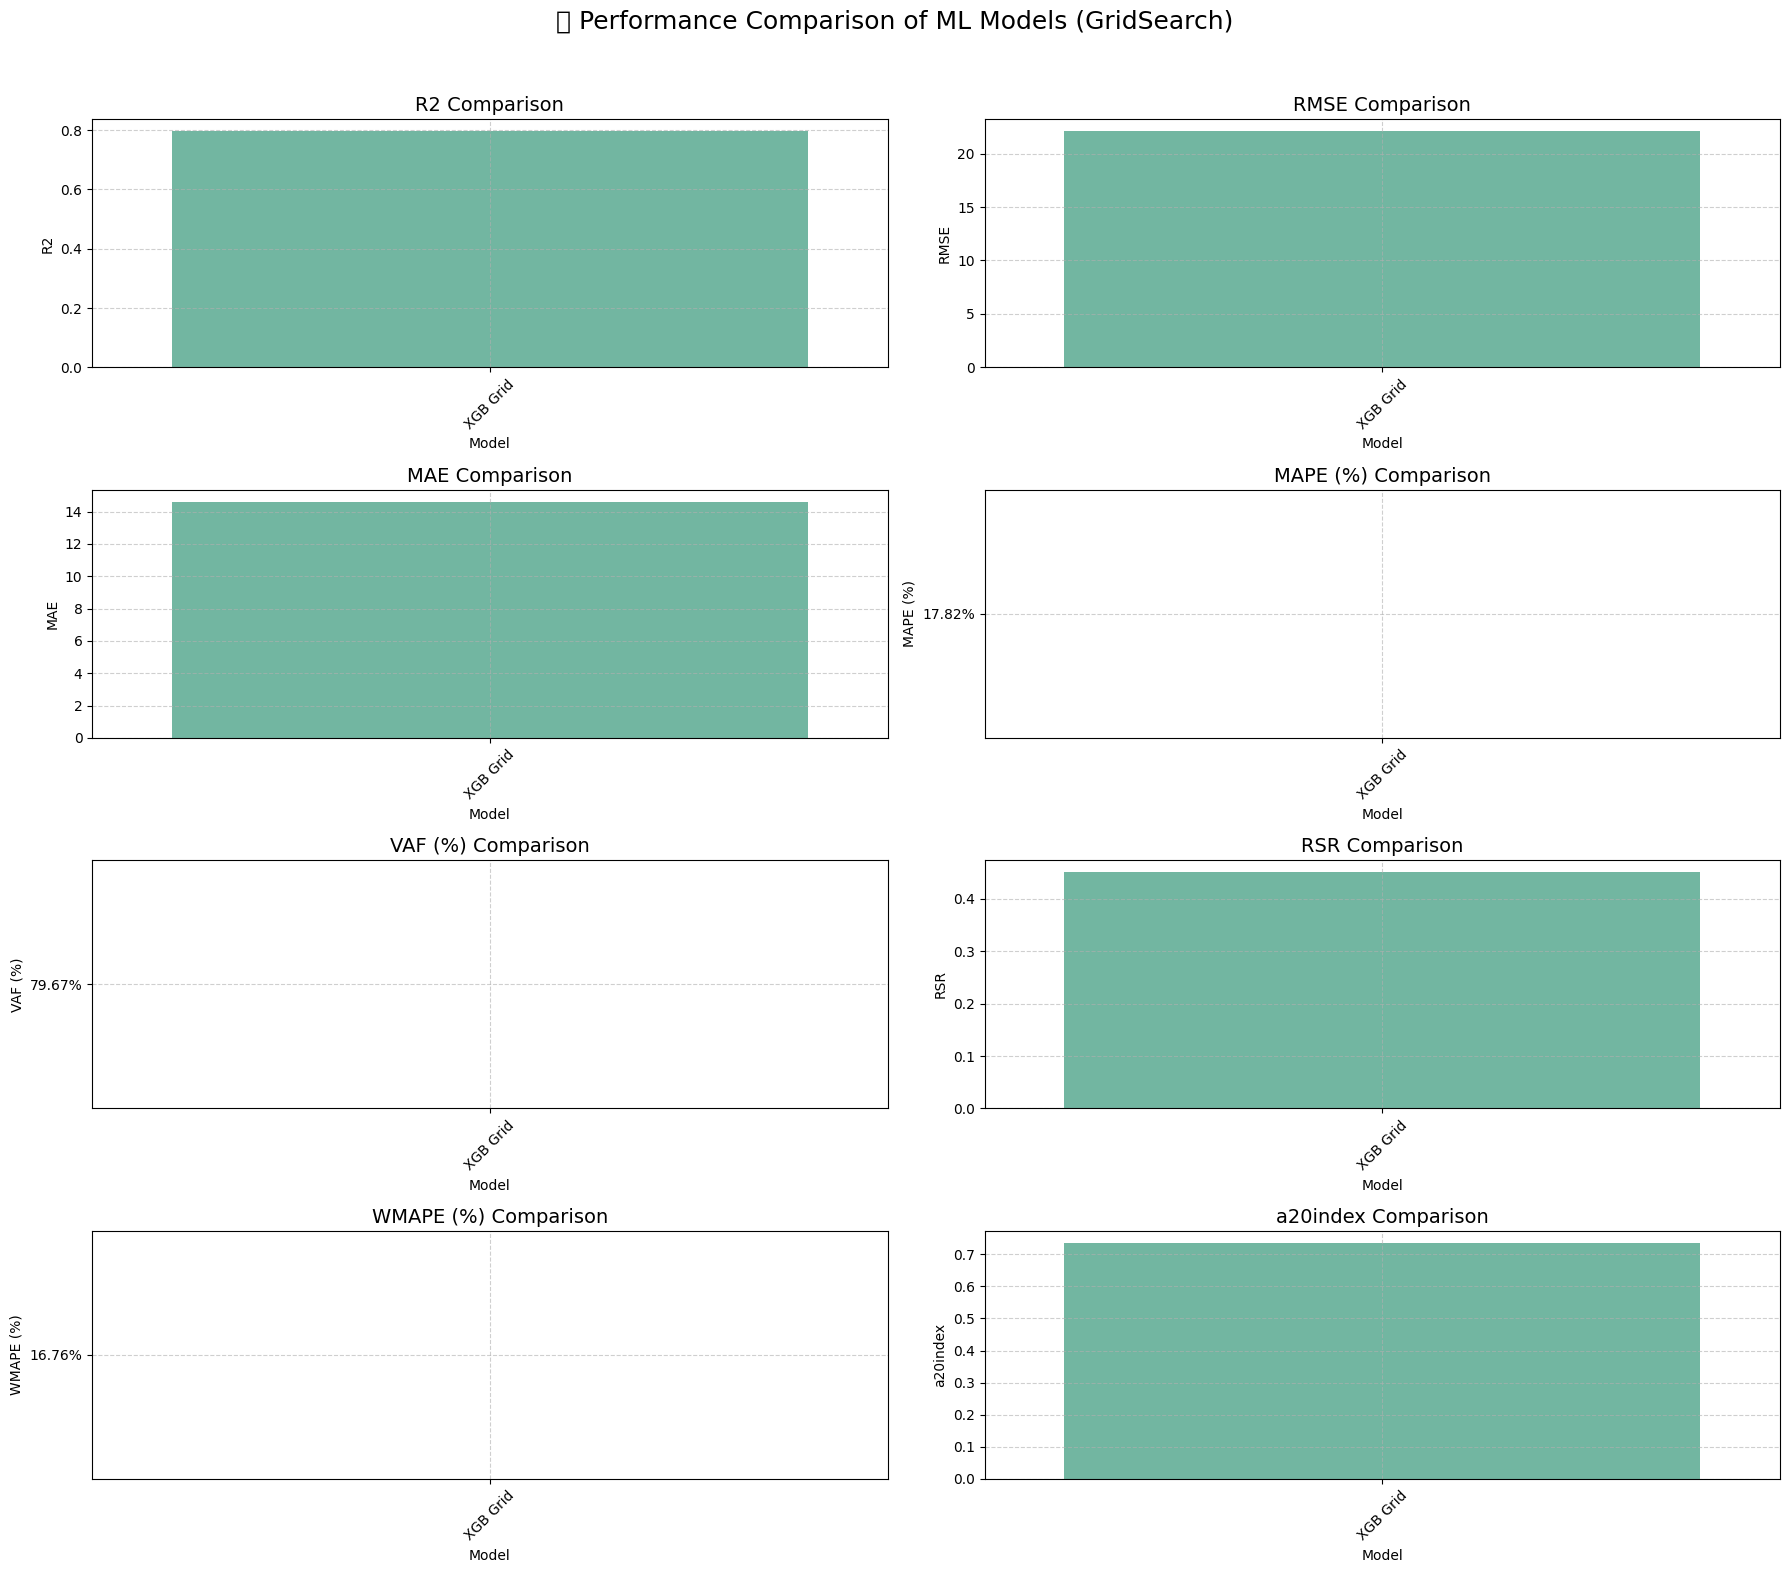

In [7]:
# === 📈 Visual Comparison (Corrected) ===
metrics_list = ["R2", "RMSE", "MAE", "MAPE (%)",
                "VAF (%)", "RSR", "WMAPE (%)", "a20index"]

num_metrics = len(metrics_list)
cols = 2
rows = int(np.ceil(num_metrics / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows
colors = sns.color_palette("Set2", n_colors=len(df_results))

for i, metric in enumerate(metrics_list):
    sns.barplot(data=df_results, x="Model", y=metric, ax=axes[i], palette=colors)
    axes[i].set_title(f"{metric} Comparison", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("📊 Performance Comparison of ML Models (GridSearch)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## SHAP Analysis

In [8]:
## Step 1: Install SHAP and Import
!pip install shap --quiet
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00


In [9]:
## Step 2: SHAP Explainer for Best XGBoost
# ✅ Create SHAP Explainer
best_xgb = xgb_grid.best_estimator_
explainer = shap.TreeExplainer(best_xgb)

# ✅ Compute SHAP values for test set
shap_values_test = explainer.shap_values(X_test_scaled)
shap_values_test_np = shap_values_test if isinstance(shap_values_test, np.ndarray) else np.array(shap_values_test)

# ✅ Feature names
feature_names = X.columns


/tmp/ipython-input-651369455.py:19: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


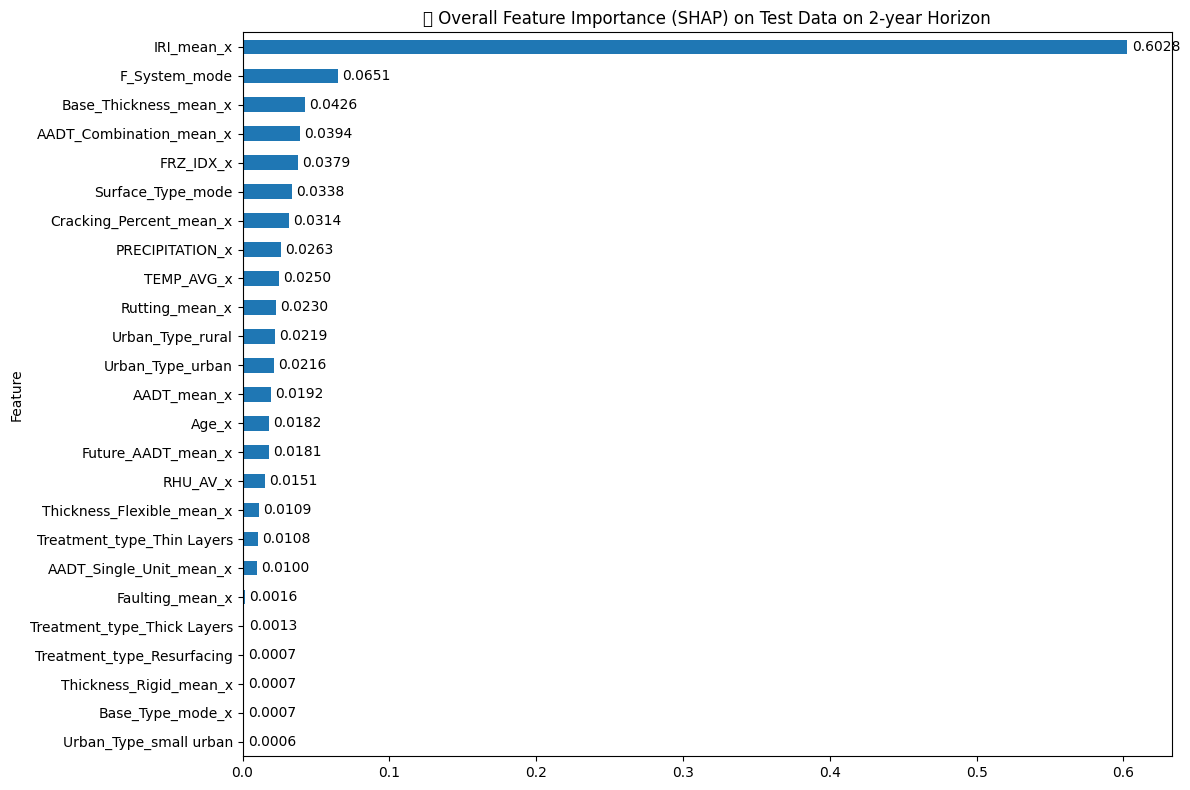

In [10]:
## Step 3: Overall Feature Importance
mean_shap = np.abs(shap_values_test_np).mean(axis=0)
shap_df = pd.DataFrame({'Feature': feature_names, 'Mean |SHAP value|': mean_shap})
shap_df = shap_df.sort_values(by='Mean |SHAP value|', ascending=True)

# ✅ Plot horizontal bar chart
ax = shap_df.plot.barh(
    x='Feature',
    y='Mean |SHAP value|',
    figsize=(12, 8),
    legend=False
)

# ✅ Add annotations for each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', label_type='edge', padding=3)

plt.title('🌟 Overall Feature Importance (SHAP) on Test Data on 2-year Horizon')
plt.tight_layout()
plt.show()


In [11]:
X_test.columns

Index(['AADT_mean_x', 'AADT_Single_Unit_mean_x', 'AADT_Combination_mean_x',
       'Future_AADT_mean_x', 'IRI_mean_x', 'Thickness_Rigid_mean_x',
       'Thickness_Flexible_mean_x', 'Base_Thickness_mean_x', 'F_System_mode',
       'Surface_Type_mode', 'Base_Type_mode_x', 'Rutting_mean_x',
       'Cracking_Percent_mean_x', 'Faulting_mean_x', 'RHU_AV_x', 'FRZ_IDX_x',
       'TEMP_AVG_x', 'PRECIPITATION_x', 'Age_x', 'Urban_Type_rural',
       'Urban_Type_small urban', 'Urban_Type_urban',
       'Treatment_type_Resurfacing', 'Treatment_type_Thick Layers',
       'Treatment_type_Thin Layers'],
      dtype='object')

In [12]:
X_test.describe()

AADT_mean_x  AADT_Single_Unit_mean_x  AADT_Combination_mean_x  \
count     868.000000               868.000000               868.000000   
mean    24103.260023              1064.413134              1971.775000   
std     30930.534799              1378.188590              3254.077165   
min        20.000000                 0.000000                 0.000000   
25%      5060.000000               180.500000               115.250000   
50%     13388.000000               551.000000               401.000000   
75%     28125.000000              1287.250000              2441.000000   
max    231000.000000             10344.000000             19581.000000   

       Future_AADT_mean_x  IRI_mean_x  Thickness_Rigid_mean_x  \
count          868.000000  868.000000              868.000000   
mean         29998.051498  110.141129                2.826152   
std          38095.632031   62.669539                4.488426   
min             50.000000   33.000000                0.000000   
25%           6390.000000   65.000000                0.000000   
50%          16693.000000   92.000000                0.000000   
75%          36000.000000  137.150000                7.000000   
max         294983.000000  388.000000               20.000000   

       Thickness_Flexible_mean_x  Base_Thickness_mean_x  F_System_mode  \
count                 868.000000             868.000000     868.000000   
mean                    6.250115              12.339401       2.706221   
std                     3.696451               7.401854       1.444109   
min                     0.000000               1.000000       1.000000   
25%                     4.000000               7.000000       1.000000   
50%                     5.600000              10.000000       3.000000   
75%                     8.000000              16.025000       4.000000   
max                    28.000000              44.000000       6.000000   

       Surface_Type_mode  ...    FRZ_IDX_x  TEMP_AVG_x  PRECIPITATION_x  \
count         868.000000  ...   868.000000  868.000000       868.000000   
mean            4.517281  ...   343.132143   10.798157      1178.134793   
std             2.190664  ...   328.594164    4.250400       379.208993   
min             2.000000  ...     0.000000    0.500000       231.400000   
25%             2.000000  ...    61.250000    8.100000      1048.550000   
50%             6.000000  ...   292.100000   10.250000      1292.650000   
75%             6.000000  ...   462.000000   12.325000      1379.000000   
max             7.000000  ...  1590.400000   25.300000      3145.300000   

            Age_x  Urban_Type_rural  Urban_Type_small urban  Urban_Type_urban  \
count  868.000000        868.000000              868.000000        868.000000   
mean    47.820276          0.368664                0.125576          0.505760   
std     25.230517          0.482721                0.331562          0.500255   
min      8.000000          0.000000                0.000000          0.000000   
25%     27.000000          0.000000                0.000000          0.000000   
50%     47.000000          0.000000                0.000000          1.000000   
75%     65.000000          1.000000                0.000000          1.000000   
max    125.000000          1.000000                1.000000          1.000000   

       Treatment_type_Resurfacing  Treatment_type_Thick Layers  \
count                  868.000000                   868.000000   
mean                     0.069124                     0.269585   
std                      0.253812                     0.444000   
min                      0.000000                     0.000000   
25%                      0.000000                     0.000000   
50%                      0.000000                     0.000000   
75%                      0.000000                     1.000000   
max                      1.000000                     1.000000   

       Treatment_type_Thin Layers  
count                  868.000000  
mean            

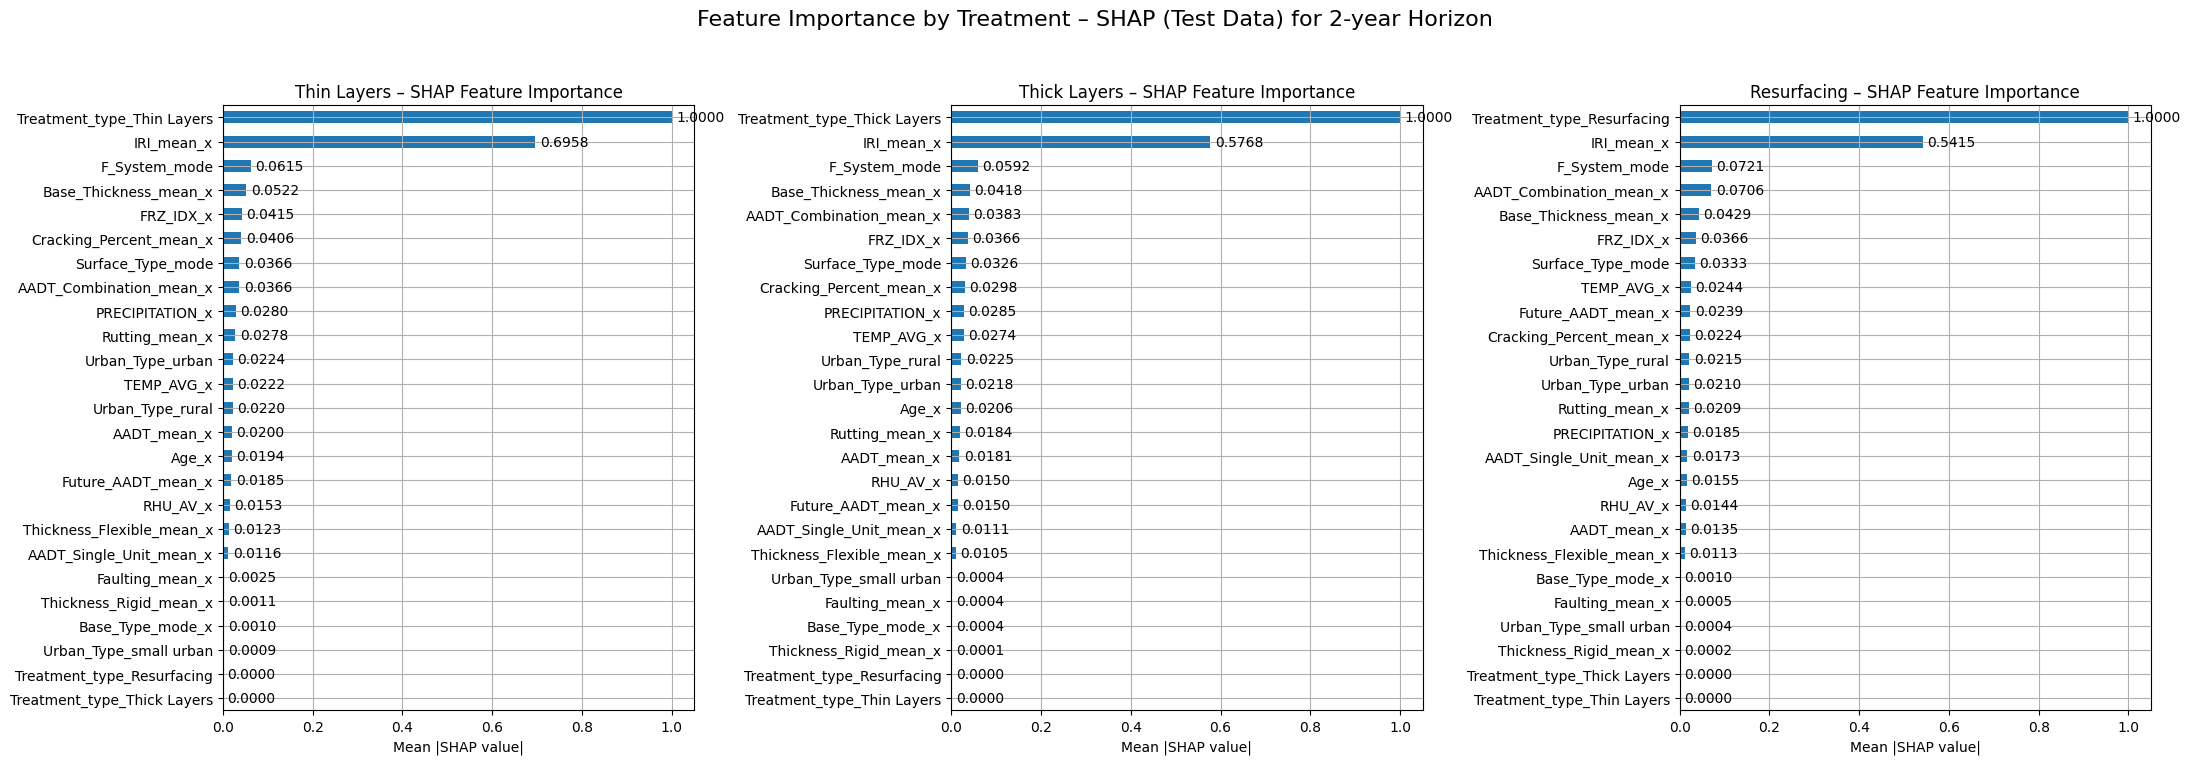

In [13]:
## Step 4: SHAP by Treatment Type
# ✅ Prepare test data with treatment flags
X_test_unscaled_df = X_test.copy()
X_test_unscaled_df['Treatment_type_Thin Layers'] = X_test['Treatment_type_Thin Layers']
X_test_unscaled_df['Treatment_type_Thick Layers'] = X_test['Treatment_type_Thick Layers']
X_test_unscaled_df['Treatment_type_Resurfacing'] = X_test['Treatment_type_Resurfacing']

# ✅ SHAP dataframe
shap_data_test = pd.DataFrame(shap_values_test_np, columns=feature_names)
shap_data_test[['Treatment_type_Thin Layers',
                'Treatment_type_Thick Layers',
                'Treatment_type_Resurfacing']] = X_test_unscaled_df[[
    'Treatment_type_Thin Layers',
    'Treatment_type_Thick Layers',
    'Treatment_type_Resurfacing'
]]

treatments = {
    'Thin Layers': 'Treatment_type_Thin Layers',
    'Thick Layers': 'Treatment_type_Thick Layers',
    'Resurfacing': 'Treatment_type_Resurfacing'
}

fig, axes = plt.subplots(1, 3, figsize=(22, 8))
for i, (label, col) in enumerate(treatments.items()):
    subset = shap_data_test[shap_data_test[col] == 1]
    if subset.empty:
        axes[i].set_visible(False)
        continue

    mean_shap = np.abs(subset[feature_names]).mean().sort_values()
    bars = mean_shap.plot.barh(ax=axes[i])

    # ✅ Annotate values on each bar
    for idx, value in enumerate(mean_shap):
        axes[i].text(
            value + (0.01 * mean_shap.max()),  # Slight offset to the right of the bar
            idx,
            f"{value:.4f}",
            va='center',
            fontsize=10
        )

    axes[i].set_title(f'{label} – SHAP Feature Importance')
    axes[i].set_xlabel("Mean |SHAP value|")
    axes[i].grid(True)

plt.suptitle("Feature Importance by Treatment – SHAP (Test Data) for 2-year Horizon", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [14]:
shap_data_test.head(10)

AADT_mean_x  AADT_Single_Unit_mean_x  AADT_Combination_mean_x  \
0    -0.045893                 0.007496                 0.041902   
1    -0.010861                -0.004633                -0.048697   
2    -0.016152                -0.000909                 0.002387   
3    -0.011470                -0.003463                -0.025131   
4     0.008034                 0.007049                -0.001670   
5    -0.004350                -0.001738                -0.004575   
6    -0.180974                -0.004262                -0.002135   
7    -0.002428                -0.007809                -0.054001   
8    -0.009139                 0.000555                -0.021693   
9     0.015916                -0.003519                -0.004630   

   Future_AADT_mean_x  IRI_mean_x  Thickness_Rigid_mean_x  \
0           -0.003203   -0.824401                0.000134   
1           -0.038545   -0.624146               -0.000115   
2           -0.012043   -0.066859                0.000413   
3           -0.006961   -0.906697                0.000091   
4           -0.004937    0.007352                0.000041   
5           -0.019860   -0.246481                0.008871   
6            0.003526    2.659711               -0.002613   
7           -0.007444   -0.371938                0.000030   
8           -0.003421   -0.436951                0.002392   
9            0.002876    0.712676                0.000947   

   Thickness_Flexible_mean_x  Base_Thickness_mean_x  F_System_mode  \
0                  -0.010522              -0.034005       0.062276   
1                  -0.009901               0.002983      -0.075023   
2                   0.024905               0.049823       0.064376   
3                  -0.002885               0.011048      -0.071193   
4                  -0.000401               0.015002       0.054981   
5                   0.016188               0.004398       0.057188   
6                  -0.006137               0.031217       0.031523   
7                  -0.005774              -0.041485      -0.084037   
8                   0.009411               0.051914      -0.073986   
9                  -0.002279               0.050557       0.061795   

   Surface_Type_mode  ...  FRZ_IDX_x  TEMP_AVG_x  PRECIPITATION_x     Age_x  \
0          -0.018799  ...  -0.067103    0.038264         0.067409 -0.003386   
1          -0.026600  ...   0.020487   -0.010746        -0.019874 -0.005860   
2           0.022813  ...  -0.077984   -0.007027         0.000559 -0.000138   
3           0.026041  ...  -0.039084    0.018630         0.010676  0.013389   
4           0.038725  ...   0.042776    0.000091         0.040275  0.009898   
5           0.024315  ...  -0.029010    0.016989         0.001126 -0.009237   
6           0.072606  ...   0.010898    0.019059         0.012567 -0.035379   
7          -0.028482  ...   0.018306    0.007470        -0.016886 -0.005051   
8           0.024315  ...  -0.104447    0.019527         0.001229 -0.003449   
9          -0.050835  ...   0.018179    0.005091        -0.009266 -0.001425   

   Urban_Type_rural  Urban_Type_small urban  Urban_Type_urban  \
0         -0.014956                0.002327         -0.028779   
1          0.012399                0.000171          0.016156   
2          0.020025                0.000787          0.016019   
3         -0.013508                0.002327         -0.024556   
4          0.021243               -0.000758         -0.009299   
5          0.020277               -0.000963         -0.023014   
6         -0.004619                0.000171          0.008679   
7         -0.027521                0.000171         -0.022327   
8         -0.021860                0.005307         -0.033392   
9          0.021295               -0.000758         -0.024192   

   Treatment_type_Resurfacing  Treatment_type_Thick Layers  \
0                         NaN                          NaN   
1                         NaN                          NaN   
2                         NaN          

## Thin Layer - based SHAP analysis

📊 Descriptive Statistics for Thin Layers:


count         mean          std   min      25%  \
IRI_mean_x               106.0   102.437736    53.870687  35.5   69.175   
AADT_Combination_mean_x  106.0  1573.553774  2616.257765   0.0  149.000   
F_System_mode            106.0     2.622642     1.275803   1.0    1.000   
Base_Thickness_mean_x    106.0    13.312264     7.019560   1.0    8.000   
FRZ_IDX_x                106.0   310.583019   310.188496   0.0   49.800   
Cracking_Percent_mean_x  106.0     3.574528     7.286283   0.0    0.000   
Urban_Type_rural         106.0     0.433962     0.497974   0.0    0.000   
Rutting_mean_x           106.0     0.200943     0.124591   0.0    0.100   

                            50%       75%      max      variance  skewness  \
IRI_mean_x                90.30   121.900    388.0  2.902051e+03  2.271314   
AADT_Combination_mean_x  442.50  1983.000  14507.0  6.844805e+06  2.651632   
F_System_mode              3.00     4.000      5.0  1.627673e+00 -0.013210   
Base_Thickness_mean_x     12.00    19.000     29.0  4.927423e+01  0.385960   
FRZ_IDX_x                231.25   462.000   1442.7  9.621690e+04  1.231503   
Cracking_Percent_mean_x    0.30     3.775     43.0  5.308992e+01  3.328561   
Urban_Type_rural           0.00     1.000      1.0  2.479784e-01  0.270326   
Rutting_mean_x             0.20     0.300      0.8  1.552291e-02  1.367130   

                          kurtosis  
IRI_mean_x                7.938724  
AADT_Combination_mean_x   7.607173  
F_System_mode            -1.178589  
Base_Thickness_mean_x    -0.828221  
FRZ_IDX_x                 1.131561  
Cracking_Percent_mean_x  12.995848  
Urban_Type_rural         -1.964353  
Rutting_mean_x            3.878643

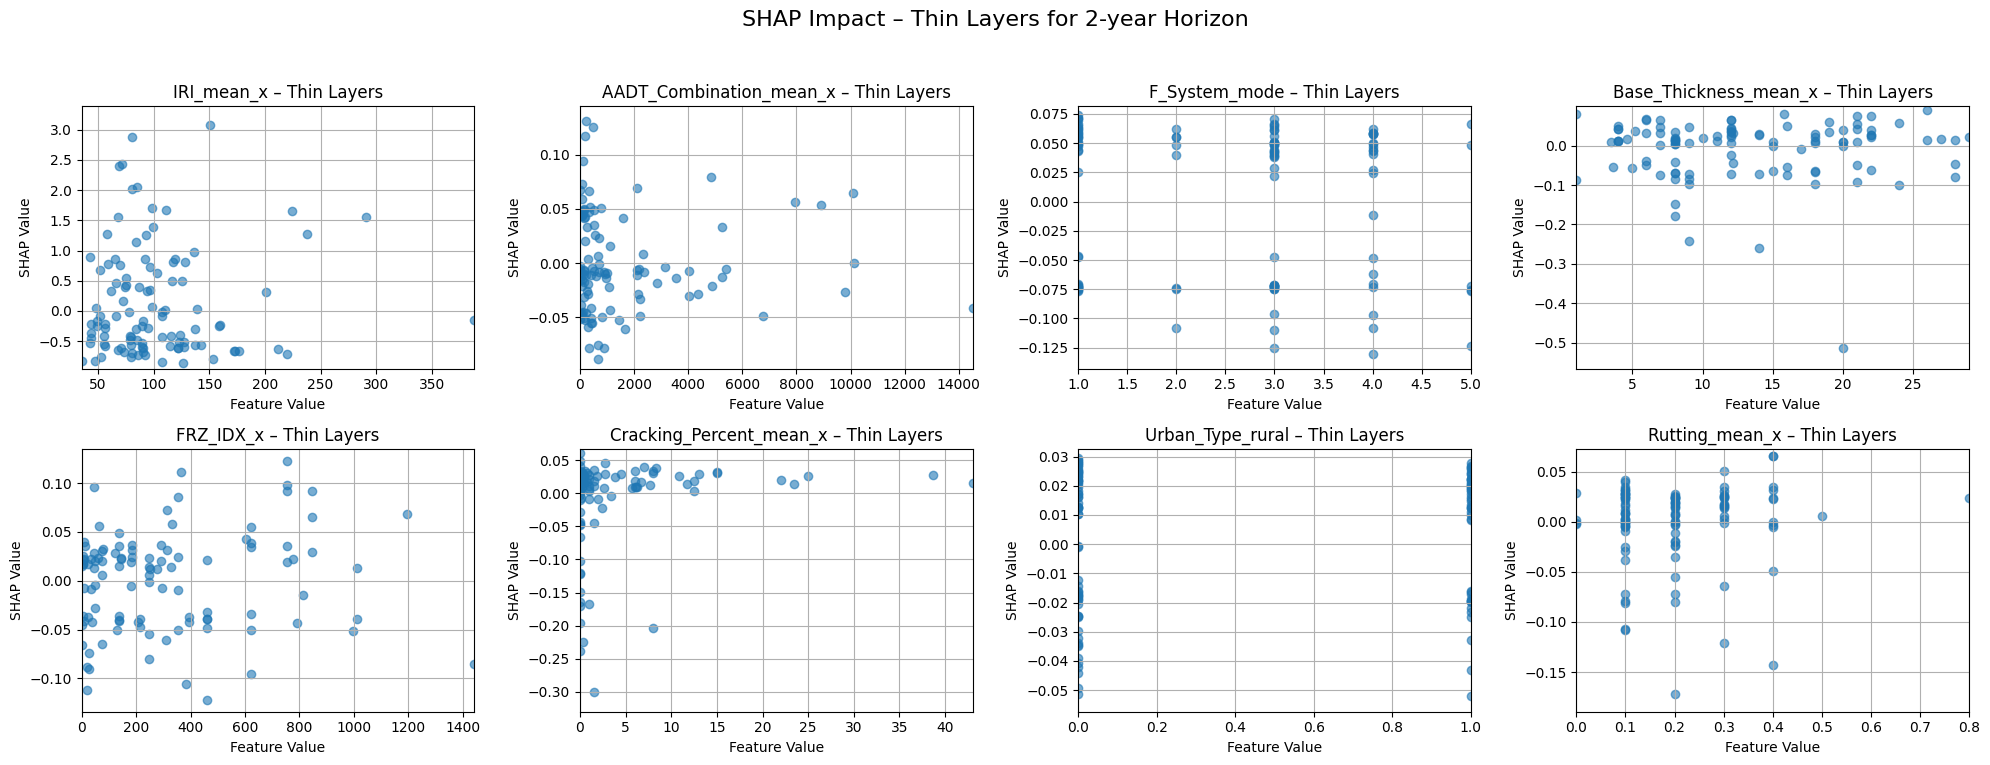

✅ Saved Thin Layers SHAP plot to: shap_group_plots/SHAP_Thin_Layers.png


In [15]:
import os
import math
import matplotlib.pyplot as plt

# ✅ Output directory
output_dir = "shap_group_plots"
os.makedirs(output_dir, exist_ok=True)

# ✅ Selected features for plotting
selected_features = [
    'IRI_mean_x', "AADT_Combination_mean_x", 'F_System_mode',
    'Base_Thickness_mean_x', 'FRZ_IDX_x', 'Cracking_Percent_mean_x',
    'Urban_Type_rural', 'Rutting_mean_x'
]

# ✅ Filter Thin Layers only
thin_subset = shap_data_test[shap_data_test['Treatment_type_Thin Layers'] == 1]

if thin_subset.empty:
    print("⚠️ No data available for Thin Layers")
else:
    # ✅ Calculate descriptive stats for Thin Layers
    desc_stats_thin = X_test.loc[thin_subset.index, selected_features].describe().T
    desc_stats_thin['variance'] = X_test.loc[thin_subset.index, selected_features].var()
    desc_stats_thin['skewness'] = X_test.loc[thin_subset.index, selected_features].skew()
    desc_stats_thin['kurtosis'] = X_test.loc[thin_subset.index, selected_features].kurt()

    print("📊 Descriptive Statistics for Thin Layers:")
    display(desc_stats_thin)

    # ✅ Axis limits based on descriptive stats
    x_lims_thin = {
        feature: (
            desc_stats_thin.loc[feature, 'min'],
            desc_stats_thin.loc[feature, 'max']
        )
        for feature in selected_features
    }

    # ✅ Dynamic subplot layout (max 4 columns)
    n_features = len(selected_features)
    n_cols = 4
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]

    for i, feature in enumerate(selected_features):
        axes[i].scatter(
            X_test.loc[thin_subset.index, feature],
            thin_subset[feature],
            alpha=0.6
        )
        axes[i].set_title(f"{feature} – Thin Layers")
        axes[i].set_xlabel("Feature Value")
        axes[i].set_ylabel("SHAP Value")
        axes[i].grid(True)
        axes[i].set_xlim(x_lims_thin[feature])  # Fixed X axis
        y_min, y_max = thin_subset[feature].min(), thin_subset[feature].max()
        axes[i].set_ylim(y_min - abs(0.1 * y_min), y_max + abs(0.1 * y_max))

    # ✅ Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("SHAP Impact – Thin Layers for 2-year Horizon", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = "SHAP_Thin_Layers.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"✅ Saved Thin Layers SHAP plot to: {filepath}")


## Thick Layer - based SHAP analysis

📊 Descriptive Statistics for Thick Layers:


count         mean          std   min    25%     50%  \
IRI_mean_x                21.0    74.714286    25.317509  42.3   55.0    69.4   
AADT_Combination_mean_x   21.0  2335.142857  2741.549822  97.0  295.0  1125.0   
F_System_mode             21.0     2.047619     1.116969   1.0    1.0     2.0   
Base_Thickness_mean_x     21.0     9.461905     4.018766   4.0    6.4     8.0   
FRZ_IDX_x                 21.0   376.190476   427.222118  36.1   49.8   181.5   
Cracking_Percent_mean_x   21.0     0.542857     1.480058   0.0    0.0     0.0   
Urban_Type_rural          21.0     0.285714     0.462910   0.0    0.0     0.0   
Rutting_mean_x            21.0     0.171429     0.134695   0.0    0.1     0.1   

                            75%     max      variance  skewness   kurtosis  
IRI_mean_x                 87.5   133.0  6.409763e+02  0.703412  -0.212087  
AADT_Combination_mean_x  3490.0  8866.0  7.516095e+06  1.372007   0.781472  
F_System_mode               3.0     5.0  1.247619e+00  0.849959   0.508482  
Base_Thickness_mean_x      12.0    18.0  1.615048e+01  0.581401  -0.415381  
FRZ_IDX_x                 462.0  1242.9  1.825187e+05  1.201887  -0.119658  
Cracking_Percent_mean_x     0.3     6.6  2.190571e+00  3.813303  15.526088  
Urban_Type_rural            1.0     1.0  2.142857e-01  1.023275  -1.064327  
Rutting_mean_x              0.2     0.5  1.814286e-02  1.121469   0.528796

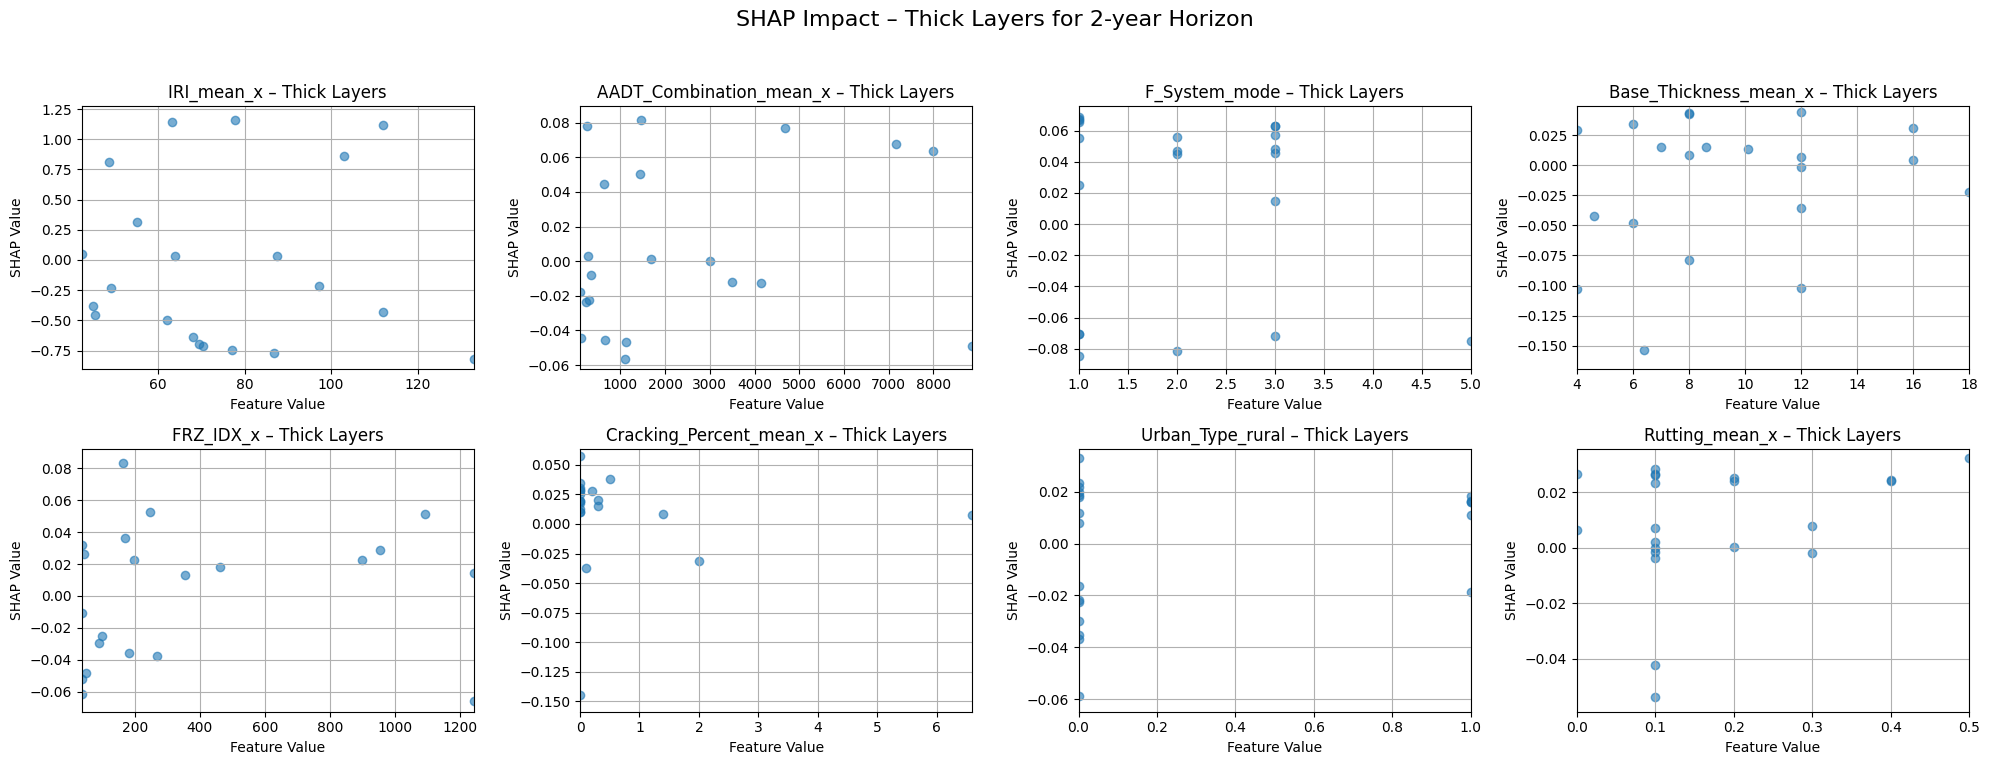

✅ Saved Thin Layers SHAP plot to: shap_group_plots/SHAP_Thick_Layers.png


In [16]:
import os
import math
import matplotlib.pyplot as plt

# ✅ Output directory
output_dir = "shap_group_plots"
os.makedirs(output_dir, exist_ok=True)

# ✅ Selected features for plotting
selected_features = [
    'IRI_mean_x', "AADT_Combination_mean_x", 'F_System_mode',
    'Base_Thickness_mean_x', 'FRZ_IDX_x', 'Cracking_Percent_mean_x',
    'Urban_Type_rural', 'Rutting_mean_x'
]

# ✅ Filter Thin Layers only
thin_subset = shap_data_test[shap_data_test['Treatment_type_Thick Layers'] == 1]

if thin_subset.empty:
    print("⚠️ No data available for Thick Layers")
else:
    # ✅ Calculate descriptive stats for Thin Layers
    desc_stats_thin = X_test.loc[thin_subset.index, selected_features].describe().T
    desc_stats_thin['variance'] = X_test.loc[thin_subset.index, selected_features].var()
    desc_stats_thin['skewness'] = X_test.loc[thin_subset.index, selected_features].skew()
    desc_stats_thin['kurtosis'] = X_test.loc[thin_subset.index, selected_features].kurt()

    print("📊 Descriptive Statistics for Thick Layers:")
    display(desc_stats_thin)

    # ✅ Axis limits based on descriptive stats
    x_lims_thin = {
        feature: (
            desc_stats_thin.loc[feature, 'min'],
            desc_stats_thin.loc[feature, 'max']
        )
        for feature in selected_features
    }

    # ✅ Dynamic subplot layout (max 4 columns)
    n_features = len(selected_features)
    n_cols = 4
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]

    for i, feature in enumerate(selected_features):
        axes[i].scatter(
            X_test.loc[thin_subset.index, feature],
            thin_subset[feature],
            alpha=0.6
        )
        axes[i].set_title(f"{feature} – Thick Layers")
        axes[i].set_xlabel("Feature Value")
        axes[i].set_ylabel("SHAP Value")
        axes[i].grid(True)
        axes[i].set_xlim(x_lims_thin[feature])  # Fixed X axis
        y_min, y_max = thin_subset[feature].min(), thin_subset[feature].max()
        axes[i].set_ylim(y_min - abs(0.1 * y_min), y_max + abs(0.1 * y_max))

    # ✅ Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("SHAP Impact – Thick Layers for 2-year Horizon", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = "SHAP_Thick_Layers.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"✅ Saved Thin Layers SHAP plot to: {filepath}")


📊 Descriptive Statistics for Resurfacing:


count      mean          std    min    25%     50%  \
IRI_mean_x                25.0    68.756    24.981328   37.0   51.0    64.3   
AADT_Combination_mean_x   25.0  2866.280  2647.369678  250.0  970.0  1666.0   
F_System_mode             25.0     1.280     0.541603    1.0    1.0     1.0   
Base_Thickness_mean_x     25.0    12.000     5.385165    4.0    8.0    10.0   
FRZ_IDX_x                 25.0   284.896   395.294650    3.6   14.3    36.5   
Cracking_Percent_mean_x   25.0     2.312     7.012686    0.0    0.0     0.0   
Urban_Type_rural          25.0     0.360     0.489898    0.0    0.0     0.0   
Rutting_mean_x            25.0     0.104     0.120692    0.0    0.0     0.1   

                            75%     max      variance  skewness   kurtosis  
IRI_mean_x                 75.8   149.2  6.240667e+02  1.517377   3.403505  
AADT_Combination_mean_x  4252.0  9160.0  7.008566e+06  1.106387   0.214336  
F_System_mode               1.0     3.0  2.933333e-01  1.863705   2.937784  
Base_Thickness_mean_x      16.0    26.0  2.900000e+01  0.969193   1.081028  
FRZ_IDX_x                 469.4  1368.6  1.562579e+05  1.565228   1.767578  
Cracking_Percent_mean_x     0.3    33.2  4.917777e+01  3.974684  16.940616  
Urban_Type_rural            1.0     1.0  2.400000e-01  0.621247  -1.762187  
Rutting_mean_x              0.2     0.4  1.456667e-02  0.845039  -0.251406

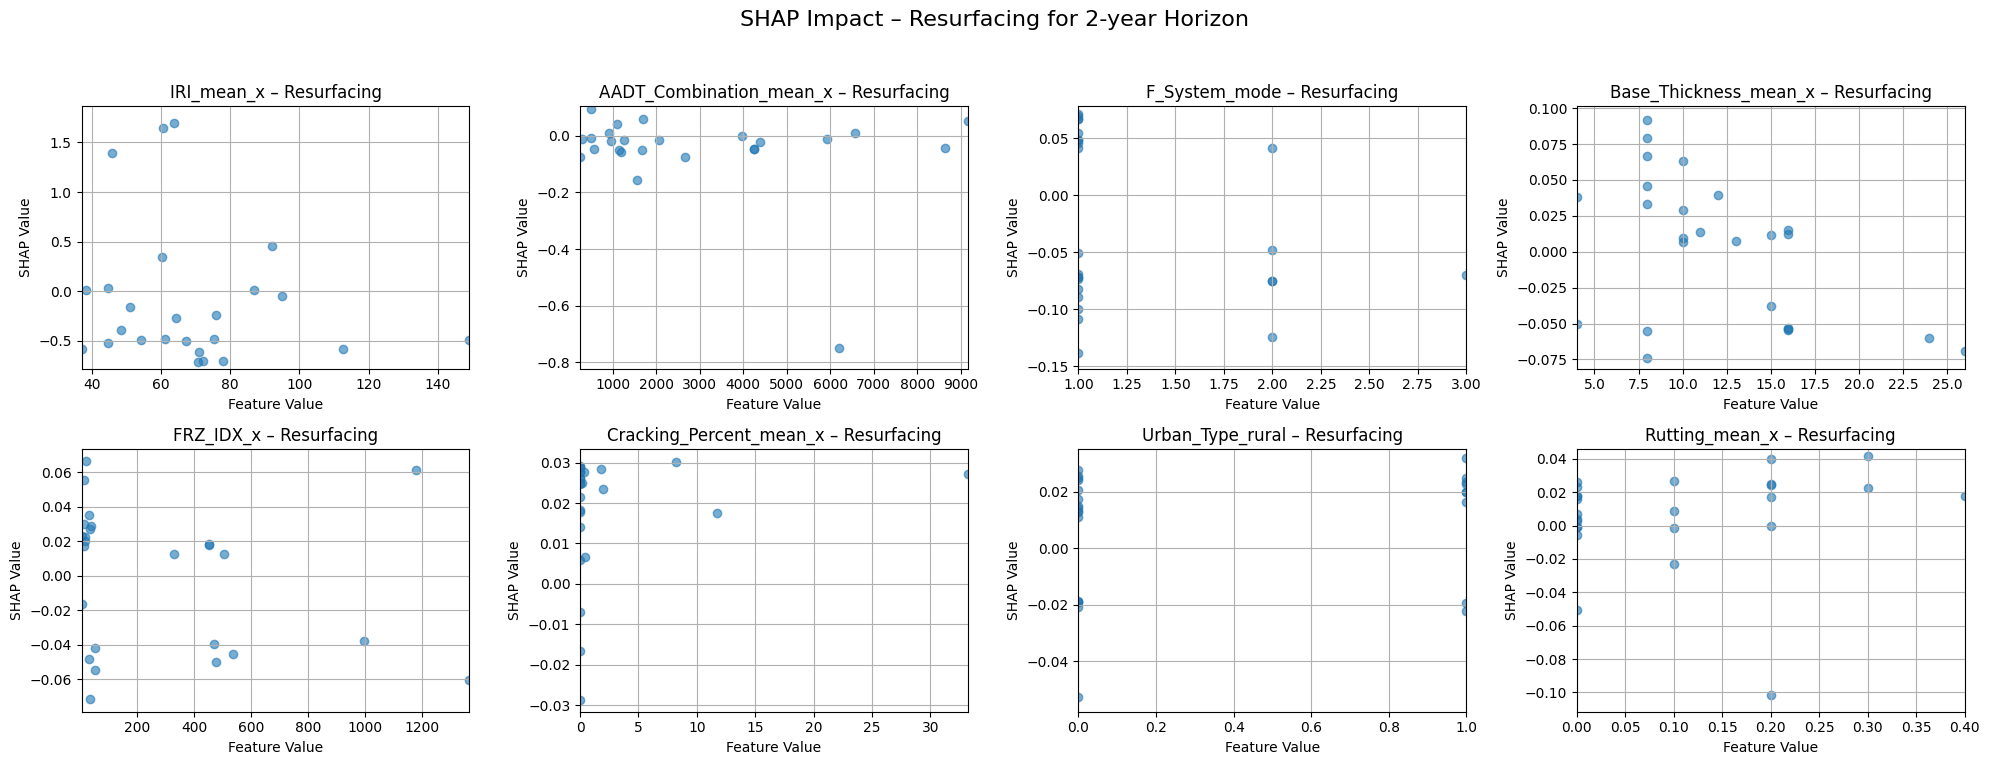

✅ Saved Resurfacing SHAP plot to: shap_group_plots/SHAP_Resurfacing.png


In [17]:
import os
import math
import matplotlib.pyplot as plt

# ✅ Output directory
output_dir = "shap_group_plots"
os.makedirs(output_dir, exist_ok=True)

# ✅ Selected features for plotting
selected_features = [
    'IRI_mean_x', "AADT_Combination_mean_x", 'F_System_mode',
    'Base_Thickness_mean_x', 'FRZ_IDX_x', 'Cracking_Percent_mean_x',
    'Urban_Type_rural', 'Rutting_mean_x'
]

# ✅ Filter Thin Layers only
thin_subset = shap_data_test[shap_data_test['Treatment_type_Resurfacing'] == 1]

if thin_subset.empty:
    print("⚠️ No data available for Resurfacing")
else:
    # ✅ Calculate descriptive stats for Thin Layers
    desc_stats_thin = X_test.loc[thin_subset.index, selected_features].describe().T
    desc_stats_thin['variance'] = X_test.loc[thin_subset.index, selected_features].var()
    desc_stats_thin['skewness'] = X_test.loc[thin_subset.index, selected_features].skew()
    desc_stats_thin['kurtosis'] = X_test.loc[thin_subset.index, selected_features].kurt()

    print("📊 Descriptive Statistics for Resurfacing:")
    display(desc_stats_thin)

    # ✅ Axis limits based on descriptive stats
    x_lims_thin = {
        feature: (
            desc_stats_thin.loc[feature, 'min'],
            desc_stats_thin.loc[feature, 'max']
        )
        for feature in selected_features
    }

    # ✅ Dynamic subplot layout (max 4 columns)
    n_features = len(selected_features)
    n_cols = 4
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]

    for i, feature in enumerate(selected_features):
        axes[i].scatter(
            X_test.loc[thin_subset.index, feature],
            thin_subset[feature],
            alpha=0.6
        )
        axes[i].set_title(f"{feature} – Resurfacing")
        axes[i].set_xlabel("Feature Value")
        axes[i].set_ylabel("SHAP Value")
        axes[i].grid(True)
        axes[i].set_xlim(x_lims_thin[feature])  # Fixed X axis
        y_min, y_max = thin_subset[feature].min(), thin_subset[feature].max()
        axes[i].set_ylim(y_min - abs(0.1 * y_min), y_max + abs(0.1 * y_max))

    # ✅ Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("SHAP Impact – Resurfacing for 2-year Horizon", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = "SHAP_Resurfacing.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300)
    plt.show()

    print(f"✅ Saved Resurfacing SHAP plot to: {filepath}")
